In [1]:
# comment out this line Massimo it is for me only
!pip install scikit-image
!pip install PIL

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [52]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from IPython.display import display 
from PIL import Image

In [37]:
# load imgs
X = []
for filename in os.listdir('../dataset/images/Train/mandatory/')[:100]:
    X.append(img_to_array(load_img('../dataset/images/Train/mandatory/'+filename)))
X = np.array(X, dtype = float)
X_train = 1.0 / 255 * X

inception = keras.applications.nasnet.NASNetLarge(weights='imagenet', include_top=True, input_shape = (331, 331, 3))
inception.graph = tf.get_default_graph()

In [38]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
embed_input = Input(shape=(1000,))
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

/Users/massimo/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/massimo/anaconda/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 256, 256, 1) (1, 256, 256, 2)
[[('n03763968', 'military_uniform', 0.63565713), ('n09835506', 'ballplayer', 0.03886789), ('n04350905', 'suit', 0.011816795)]]


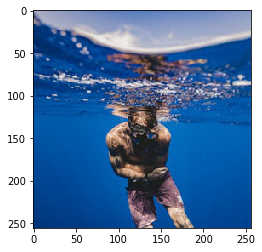

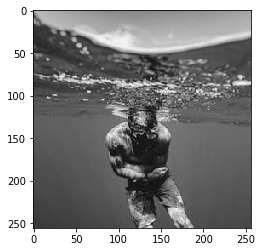

In [45]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def inception_embeddings(grays):
    grayresized = []
    for i in grays:
#         NAS uses 331*331
        i = resize(i, (331, 331, 3), mode='constant')
        grayresized.append(i)
    grayresized = np.array(grayresized)
    grayresized = preprocess_input(grayresized*255)
    with inception.graph.as_default():
        embed = inception.predict(grayresized)
    print(decode_predictions(embed, top=3))
    return embed

# augmentation
aug = ImageDataGenerator(
        #shear_range=0.5,
        #zoom_range=0.5,
        #rotation_range=10,
        horizontal_flip=True)


def image_gen(batch_size):
    for batch in aug.flow(X_train, batch_size=batch_size):
        grays = gray2rgb(rgb2gray(batch))
        #embed = inception_embeddings(grays)
        
        fig2=plt.figure()
        plt.imshow(batch[0])
        fig2.show()
        
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        
        fig=plt.figure()
        plt.imshow(X_batch[0,:,:,0], cmap='gray')
        fig.show()
        
        print(X_batch.shape, Y_batch.shape)
        
        yield ([X_batch, inception_embeddings(grays)], Y_batch)


#Train model
batch_size = 15
model.compile(optimizer='adam', loss='mse')
l=image_gen(1).__next__()
#model.fit_generator(image_gen(batch_size), epochs=5, steps_per_epoch=10)

In [7]:
tobecolored = []
for filename in os.listdir('../dataset/images/Test/'):
    tobecolored.append(img_to_array(load_img('../dataset/images/Test/'+filename)))
tobecolored = np.array(tobecolored, dtype=float)
grayout = gray2rgb(rgb2gray(1 / 255 * tobecolored))
tobecolored_embed = inception_embeddings(grayout)
# 331*331*1...blah
tobecolored = rgb2lab(1 / 255 * tobecolored)[:,:,:,0]#????????
tobecolored = tobecolored.reshape(tobecolored.shape+(1,))


# Test
output = model.predict([tobecolored, tobecolored_embed])
output = output * 128

# Output
for i in range(len(output)):
    done = np.zeros((256, 256, 3))
    done[:,:,0] = tobecolored[i][:,:,0]
    done[:,:,1:] = output[i]
    imsave("result/img_"+ str(i)+".png", lab2rgb(done))

D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
D:\Anaconda3\envs\tensorflow\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/Users/massimo/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/massimo/anaconda/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 256, 256, 1) (1, 256, 256, 2)
[[('n10148035', 'groom', 0.0565589), ('n04350905', 'suit', 0.031349715), ('n03721384', 'marimba', 0.030134754)]]
(1, 256, 256, 2)


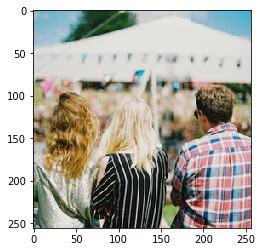

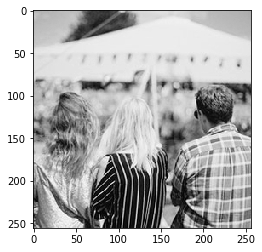

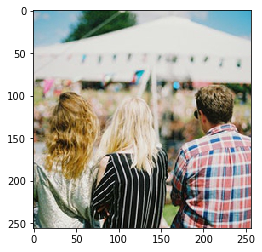

In [66]:
l=image_gen(1).__next__()
done = np.zeros((256, 256, 3))
print(l[1].shape)
done[:,:,0] = l[0][0][:,:,:,0]
done[:,:,1:] = l[1]*128
done = lab2rgb(done)
fig2=plt.figure()
plt.imshow(done)
fig2.show()